In [1]:
import pandas as pd
from rdkit import Chem # Still good to have for potential future use or validation

# Your initial dataset
initial_data = pd.DataFrame({
    'Name': ['Caffeine', 'Quinine', 'Saccharin', 'Sucrose', 'Denatonium'],
    'SMILES': [
        'Cn1cnc2c1c(=O)n(c(=O)n2C)C',
        'C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=CC4=O', # Quinine
        'C1=CC=C(C=C1)C(=O)NS(=O)(=O)O', # Saccharin
        'C(C1C(C(C(C(O1)O)O)O)O)O', # Sucrose
        'CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]' # Denatonium
    ],
    'Bitter': [1, 1, 1, 0, 1]
})


# Path to your downloaded BitterDB CSV file
csv_file_path = 'BitterCompoundsPropA_2024.csv' # Make sure this matches the filename you downloaded

try:
    # Load the new data from the CSV file
    # Ensure to use the correct column names from your provided headers
    new_bitter_compounds_df = pd.read_csv(csv_file_path)

    # Select the relevant columns and rename them to 'Name' and 'SMILES'
    # Prioritize 'IUPAC' for Name, fallback to 'cid' if 'IUPAC' is often empty or less descriptive.
    # For now, let's assume 'IUPAC' is desired for 'Name'.
    
    # Create the 'Name' column from 'IUPAC', falling back to 'cid' if IUPAC is missing or empty
    new_bitter_compounds_df['Name'] = new_bitter_compounds_df['IUPAC'].fillna(new_bitter_compounds_df['cid'])
    
    # Select 'Name' (the newly created one) and 'canonical_smiles'
    new_bitter_compounds_df = new_bitter_compounds_df[['Name', 'canonical_smiles']].copy()
    
    # Rename 'canonical_smiles' to 'SMILES' for consistency with your initial_data
    new_bitter_compounds_df.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)
    
    # Assign the 'Bitter' label as 1 (since these are all from BitterDB)
    new_bitter_compounds_df['Bitter'] = 1

    # Combine the initial data with the new data
    combined_data = pd.concat([initial_data, new_bitter_compounds_df], ignore_index=True)
    
    # Remove duplicates based on the 'SMILES' string
    combined_data.drop_duplicates(subset=['SMILES'], inplace=True)
    
    # Reset the index after dropping duplicates
    combined_data.reset_index(drop=True, inplace=True)

    print(f"Initial dataset size: {len(initial_data)}")
    print(f"New bitter compounds loaded from CSV: {len(new_bitter_compounds_df)}")
    print(f"Combined dataset size (after removing duplicates): {len(combined_data)}")

    print("\nFirst 5 rows of the combined dataset:")
    print(combined_data.head())

    print("\nLast 5 rows of the combined dataset:")
    print(combined_data.tail())

except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found. Please ensure the CSV is in the correct directory.")
except KeyError as e:
    print(f"Error: Missing expected column in CSV: {e}. Please check the CSV headers and column names in the code.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Initial dataset size: 5
New bitter compounds loaded from CSV: 2250
Combined dataset size (after removing duplicates): 2175

First 5 rows of the combined dataset:
         Name                                             SMILES  Bitter
0    Caffeine                         Cn1cnc2c1c(=O)n(c(=O)n2C)C       1
1     Quinine  C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=...       1
2   Saccharin                      C1=CC=C(C=C1)C(=O)NS(=O)(=O)O       1
3     Sucrose                           C(C1C(C(C(C(O1)O)O)O)O)O       0
4  Denatonium               CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]       1

Last 5 rows of the combined dataset:
                                                   Name  \
2170  2-[(2-aminoacetyl)amino]-N-naphthalen-2-yl-3-p...   
2171                                               2699   
2172  3-methyl-3-[[3,4,5-trihydroxy-6-(hydroxymethyl...   
2173  3-(3,4-dimethoxyphenyl)propyl 3-(3,4-dimethoxy...   
2174  2-oxo-N-(1,2,3,10-tetramethoxy-9-oxo-6,7-dihyd...   

       

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski # For some specific rule-of-5 like descriptors
from rdkit.Chem import rdMolDescriptors # For more specific ring/aromatic ring counts
import numpy as np

In [2]:
import pandas as pd

# --- 1. Your existing Bitter Data (initial sample + BitterDB export) ---
# (Keep this part as it was, unchanged)
try:
    if 'combined_data' not in locals():
        print("Using placeholder for BitterDB data. Please ensure you've run the BitterDB import code first.")
        combined_data = pd.DataFrame({
            'Name': ['Caffeine', 'Quinine', 'Saccharin', 'Denatonium', 'BitterCompoundX', 'BitterCompoundY'],
            'SMILES': [
                'Cn1cnc2c1c(=O)n(c(=O)n2C)C',
                'C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=CC4=O',
                'C1=CC=C(C=C1)C(=O)NS(=O)(=O)O',
                'CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]',
                'C1=CC=C(C=C1)C(=O)C(N)C(=O)O', # Placeholder bitter compound
                'NCCC[C@H](C(=O)O)NC(=O)C(C)(C)NC(=O)C1=CC=CC=C1' # Another placeholder
            ],
            'Bitter': [1, 1, 1, 1, 1, 1]
        })
    print(f"Current bitter dataset size (before adding non-bitter): {len(combined_data)}")

except NameError:
    print("Warning: 'combined_data' not found. Please ensure the BitterDB import step was executed.")
    combined_data = pd.DataFrame({
        'Name': ['Caffeine', 'Quinine', 'Saccharin', 'Denatonium'],
        'SMILES': [
            'Cn1cnc2c1c(=O)n(c(=O)n2C)C',
            'C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=CC4=O',
            'C1=CC=C(C=C1)C(=O)NS(=O)(=O)O',
            'CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]'
        ],
        'Bitter': [1, 1, 1, 1]
    })


# --- 2. Load and Process ChemTastesDB Data (with encoding fix) ---
chemtastesdb_csv_path = 'ChemTastesDB_database.csv' # Adjust this filename if different

try:
    # --- CHANGE IS HERE: Add the 'encoding' parameter ---
    # Common alternatives are 'latin1', 'cp1252', 'ISO-8859-1'
    # 'latin1' and 'ISO-8859-1' are often interchangeable for this kind of error.
    # 'cp1252' is common for files originating from Windows systems.
    chemtastes_df = pd.read_csv(chemtastesdb_csv_path, encoding='latin1')

    # Convert column names to lowercase and replace spaces to make them easier to work with
    chemtastes_df.columns = chemtastes_df.columns.str.lower().str.replace(' ', '_')

    # Identify non-bitter taste categories
    non_bitter_tastes = ['sweet', 'sour', 'umami', 'salty', 'tasteless', 'non-bitter', 'acidic', 'astringent', 'pungent']
    
    if 'taste' in chemtastes_df.columns:
        non_bitter_compounds_df = chemtastes_df[
            (chemtastes_df['taste'].str.lower().isin(non_bitter_tastes)) &
            (~chemtastes_df['taste'].str.lower().str.contains('bitter', na=False))
        ].copy()
    else:
        print("Warning: 'taste' column not found in ChemTastesDB. Cannot filter for non-bitter compounds effectively.")
        non_bitter_compounds_df = pd.DataFrame()

    if not non_bitter_compounds_df.empty:
        non_bitter_compounds_df = non_bitter_compounds_df[['name', 'canonical_smiles']].copy()
        non_bitter_compounds_df.rename(columns={'name': 'Name', 'canonical_smiles': 'SMILES'}, inplace=True)
        non_bitter_compounds_df['Bitter'] = 0

        print(f"Non-bitter compounds loaded from ChemTastesDB: {len(non_bitter_compounds_df)}")
    else:
        print("No non-bitter compounds found or 'taste' column missing in ChemTastesDB export.")

except FileNotFoundError:
    print(f"Error: The file '{chemtastesdb_csv_path}' was not found. Please ensure the CSV is in the correct directory.")
    non_bitter_compounds_df = pd.DataFrame()
except KeyError as e:
    print(f"Error: Missing expected column in ChemTastesDB CSV: {e}. Please check the CSV headers and column names in the code.")
    non_bitter_compounds_df = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred during ChemTastesDB processing: {e}")
    non_bitter_compounds_df = pd.DataFrame()


# --- 3. Combine All Data and Deduplicate ---
if not non_bitter_compounds_df.empty:
    final_combined_data = pd.concat([combined_data, non_bitter_compounds_df], ignore_index=True)
    final_combined_data.drop_duplicates(subset=['SMILES'], inplace=True)
    final_combined_data.reset_index(drop=True, inplace=True)

    print(f"\nTotal dataset size after adding non-bitter compounds and deduplicating: {len(final_combined_data)}")
    print(f"Number of bitter compounds: {final_combined_data['Bitter'].sum()}")
    print(f"Number of non-bitter compounds: {(final_combined_data['Bitter'] == 0).sum()}")

    print("\nFirst 5 rows of the final combined dataset:")
    print(final_combined_data.head())

    print("\nLast 5 rows of the final combined dataset:")
    print(final_combined_data.tail())

else:
    print("\nNo non-bitter data was successfully loaded or processed. The dataset remains as is.")
    final_combined_data = combined_data

Current bitter dataset size (before adding non-bitter): 2175
Non-bitter compounds loaded from ChemTastesDB: 1627

Total dataset size after adding non-bitter compounds and deduplicating: 3703
Number of bitter compounds: 2174
Number of non-bitter compounds: 1529

First 5 rows of the final combined dataset:
         Name                                             SMILES  Bitter
0    Caffeine                         Cn1cnc2c1c(=O)n(c(=O)n2C)C       1
1     Quinine  C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=...       1
2   Saccharin                      C1=CC=C(C=C1)C(=O)NS(=O)(=O)O       1
3     Sucrose                           C(C1C(C(C(C(O1)O)O)O)O)O       0
4  Denatonium               CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]       1

Last 5 rows of the final combined dataset:
                                                   Name  \
3698                                   Hamameli tannine   
3699  Methyl 1-(1-_-glucopyranosyl)-1H-indole-3-acetate   
3700                               

In [7]:
# Create empty lists to store calculated properties
mol_weights = []
alogps = []
num_h_donors = []
num_h_acceptors = []
num_rotatable_bonds = []
num_rings = []
num_aromatic_rings = []
total_charges = [] # NEW LIST FOR TOTAL CHARGE

# Iterate through each SMILES string in your DataFrame
for smiles in final_combined_data['SMILES']:
    mol = None
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as e:
        print(f"Warning: Could not parse SMILES '{smiles}': {e}")
        # If SMILES parsing fails, append NaN for all properties
        mol_weights.append(np.nan)
        alogps.append(np.nan)
        num_h_donors.append(np.nan)
        num_h_acceptors.append(np.nan)
        num_rotatable_bonds.append(np.nan)
        num_rings.append(np.nan)
        num_aromatic_rings.append(np.nan)
        total_charges.append(np.nan) # Append NaN for charge as well
        continue # Skip to the next SMILES

    if mol is not None:
        try:
            mol_weights.append(Descriptors.MolWt(mol))
            alogps.append(Descriptors.MolLogP(mol))
            num_h_donors.append(Descriptors.NumHDonors(mol))
            num_h_acceptors.append(Descriptors.NumHAcceptors(mol))
            num_rotatable_bonds.append(Descriptors.NumRotatableBonds(mol))
            num_rings.append(rdMolDescriptors.CalcNumRings(mol))
            num_aromatic_rings.append(rdMolDescriptors.CalcNumAromaticRings(mol))

            # --- Calculate Total Formal Charge ---
            # Sum the formal charges of all atoms in the molecule
            total_formal_charge = sum(atom.GetFormalCharge() for atom in mol.GetAtoms())
            total_charges.append(total_formal_charge)
            # --- End Total Formal Charge Calculation ---

        except Exception as e:
            print(f"Warning: Error calculating descriptor for '{smiles}': {e}")
            # Append NaN if descriptor calculation fails for some reason
            mol_weights.append(np.nan)
            alogps.append(np.nan)
            num_h_donors.append(np.nan)
            num_h_acceptors.append(np.nan)
            num_rotatable_bonds.append(np.nan)
            num_rings.append(np.nan)
            num_aromatic_rings.append(np.nan)
            total_charges.append(np.nan) # Append NaN for charge as well
    else: # This case is covered by the `continue` in the except block above, but good for clarity
        mol_weights.append(np.nan)
        alogps.append(np.nan)
        num_h_donors.append(np.nan)
        num_h_acceptors.append(np.nan)
        num_rotatable_bonds.append(np.nan)
        num_rings.append(np.nan)
        num_aromatic_rings.append(np.nan)
        total_charges.append(np.nan)


# Add the calculated properties as new columns to your DataFrame
final_combined_data['MW'] = mol_weights
final_combined_data['AlogP'] = alogps
final_combined_data['Num_H_Donors'] = num_h_donors
final_combined_data['Num_H_Acceptors'] = num_h_acceptors
final_combined_data['Num_RotatableBonds'] = num_rotatable_bonds
final_combined_data['Num_Rings'] = num_rings
final_combined_data['Num_AromaticRings'] = num_aromatic_rings
final_combined_data['Total_Charge'] = total_charges # ADD THE NEW COLUMN

# --- Handle Missing Values (NaNs) ---
print("\nChecking for and handling NaN values in new molecular properties...")
# Include 'Total_Charge' in the list of columns to check for NaNs
properties_to_check_for_nan = [
    'MW', 'AlogP', 'Num_H_Donors', 'Num_H_Acceptors',
    'Num_RotatableBonds', 'Num_Rings', 'Num_AromaticRings', 'Total_Charge'
]
nan_counts = final_combined_data[final_combined_data.columns.intersection(
    properties_to_check_for_nan
)].isnull().sum()
print("NaN counts per calculated property:")
print(nan_counts[nan_counts > 0])

# Fill NaNs with 0 for count-based descriptors and total charge.
# For MW/AlogP, fill with mean.
for col in ['Num_H_Donors', 'Num_H_Acceptors', 'Num_RotatableBonds', 'Num_Rings', 'Num_AromaticRings', 'Total_Charge']:
    if col in final_combined_data.columns and final_combined_data[col].isnull().any():
        final_combined_data[col].fillna(0, inplace=True)

for col in ['MW', 'AlogP']:
    if col in final_combined_data.columns and final_combined_data[col].isnull().any():
        if not final_combined_data[col].dropna().empty:
            final_combined_data[col].fillna(final_combined_data[col].mean(), inplace=True)
        else:
            final_combined_data[col].fillna(0, inplace=True)


print(f"\nFinal shape of data after adding properties and handling NaNs: {final_combined_data.shape}")
print("\nFirst 5 rows with new molecular properties (including Total_Charge):")
print(final_combined_data.head())

print("\nLast 5 rows with new molecular properties (including Total_Charge):")
print(final_combined_data.tail())

# You can now proceed with the EDA (distribution and property comparison)
# using this updated final_combined_data DataFrame, including 'Total_Charge'.

[13:14:20] WARNING: not removing hydrogen atom without neighbors



Checking for and handling NaN values in new molecular properties...
NaN counts per calculated property:
Series([], dtype: int64)

Final shape of data after adding properties and handling NaNs: (3703, 11)

First 5 rows with new molecular properties (including Total_Charge):
         Name                                             SMILES  Bitter  \
0    Caffeine                         Cn1cnc2c1c(=O)n(c(=O)n2C)C       1   
1     Quinine  C[C@@H]1CN2CC3=C(C=CC(=C3)C2CC1)C(=O)N=C4C=CC=...       1   
2   Saccharin                      C1=CC=C(C=C1)C(=O)NS(=O)(=O)O       1   
3     Sucrose                           C(C1C(C(C(C(O1)O)O)O)O)O       0   
4  Denatonium               CC[N+](C)(C)CCC1=CC=C(C=C1)C(=O)[O-]       1   

        MW   AlogP  Num_H_Donors  Num_H_Acceptors  Num_RotatableBonds  \
0  194.194 -1.0293             0                6                   0   
1  320.392  3.2495             0                3                   1   
2  201.203  0.2192             2                3


--- 1. Check Distribution of Bitter vs. Non-Bitter Compounds ---
Distribution of Bitter (1) vs. Non-Bitter (0) Compounds:
Bitter
1    2174
0    1529
Name: count, dtype: int64

Percentage Distribution:
Bitter
1    58.709155
0    41.290845
Name: proportion, dtype: float64


/var/folders/x2/ggtknn9s49s3dcq96ckcgfgh0000gn/T/ipykernel_82020/604951309.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Bitter', data=final_combined_data, palette='viridis')


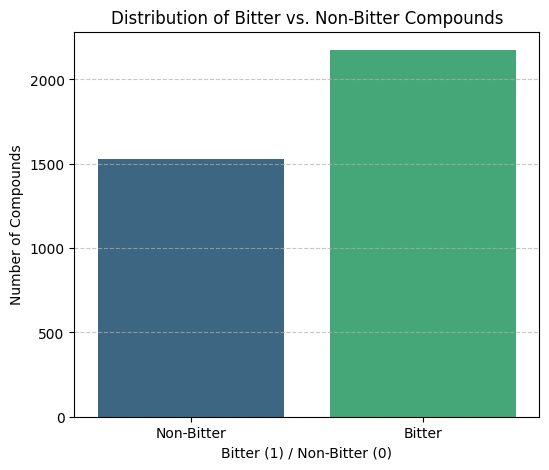


--- 2. Look at Molecular Properties by Bitterness Class ---
Analyzing available properties: MW, AlogP, Num_H_Donors, Num_H_Acceptors, Num_RotatableBonds, Num_Rings, Num_AromaticRings, Total_Charge

Descriptive Statistics (Mean and Std Dev) by Bitterness Class:

--- Property: MW ---
              mean         std
Bitter                        
0       384.660702  261.786046
1       456.978389  346.921573

--- Property: AlogP ---
            mean       std
Bitter                    
0      -0.280377  3.214493
1       1.187932  2.762182

--- Property: Num_H_Donors ---
            mean       std
Bitter                    
0       4.077175  3.997127
1       4.215731  4.763521

--- Property: Num_H_Acceptors ---
            mean       std
Bitter                    
0       6.910399  6.348451
1       6.809108  5.795875

--- Property: Num_RotatableBonds ---
            mean       std
Bitter                    
0       6.564421  5.253764
1       8.013339  9.993109

--- Property: Num_Rings ---
 

/var/folders/x2/ggtknn9s49s3dcq96ckcgfgh0000gn/T/ipykernel_82020/604951309.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bitter', y=prop, data=final_combined_data, palette='coolwarm')
/var/folders/x2/ggtknn9s49s3dcq96ckcgfgh0000gn/T/ipykernel_82020/604951309.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bitter', y=prop, data=final_combined_data, palette='coolwarm')
/var/folders/x2/ggtknn9s49s3dcq96ckcgfgh0000gn/T/ipykernel_82020/604951309.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bitter', y=prop, data=final_

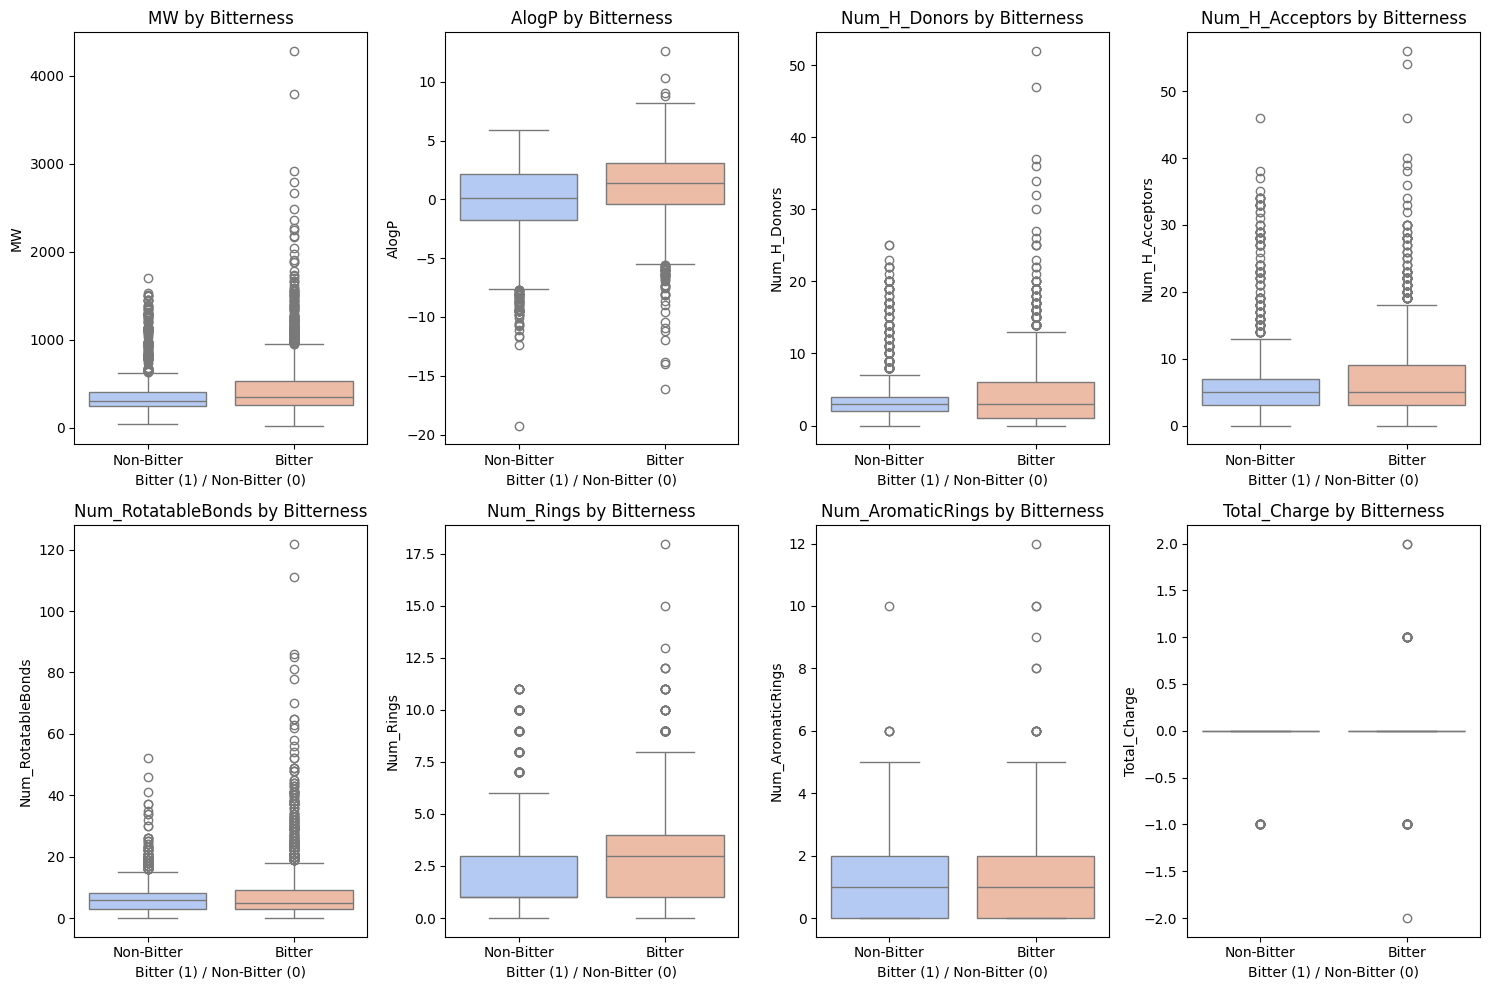

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- 1. Check Distribution of Bitter vs. Non-Bitter Compounds ---")

# Count the occurrences of each class
bitter_distribution = final_combined_data['Bitter'].value_counts()
print("Distribution of Bitter (1) vs. Non-Bitter (0) Compounds:")
print(bitter_distribution)

# Calculate percentages
bitter_percentage = final_combined_data['Bitter'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(bitter_percentage)

# Visualize the distribution
plt.figure(figsize=(6, 5))
sns.countplot(x='Bitter', data=final_combined_data, palette='viridis')
plt.title('Distribution of Bitter vs. Non-Bitter Compounds')
plt.xlabel('Bitter (1) / Non-Bitter (0)')
plt.ylabel('Number of Compounds')
plt.xticks([0, 1], ['Non-Bitter', 'Bitter'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Interpretation:
# - If the counts are very skewed (e.g., 90% bitter, 10% non-bitter), you might
#   consider techniques like oversampling (e.g., SMOTE) or undersampling
#   during model training to handle class imbalance.

print("\n--- 2. Look at Molecular Properties by Bitterness Class ---")

# Define the molecular properties you want to analyze
# Make sure these columns exist in your final_combined_data from the BitterDB export.
# If they are not present, this section will raise a KeyError.
# Common BitterDB properties:
molecular_properties = [
    'MW',             # Molecular Weight
    'AlogP',          # Octanol-Water Partition Coefficient (log P) - often related to lipophilicity
    'Num_H_Donors',   # Number of Hydrogen Bond Donors
    'Num_H_Acceptors',# Number of Hydrogen Bond Acceptors
    'Num_RotatableBonds', # Number of Rotatable Bonds
    'Num_Rings',      # Number of Rings (if present)
    'Num_AromaticRings', # Number of Aromatic Rings (if present)
    'Total_Charge'
]

# Filter out properties that might not be in your combined dataset
# (e.g., if ChemTastesDB didn't have these columns, or if you didn't merge them)
available_properties = [prop for prop in molecular_properties if prop in final_combined_data.columns]

if not available_properties:
    print("Warning: No molecular properties found in the combined dataset for analysis.")
    print("Please ensure you merged the BitterDB export with these properties correctly.")
else:
    print(f"Analyzing available properties: {', '.join(available_properties)}")

    # Calculate descriptive statistics for each group
    print("\nDescriptive Statistics (Mean and Std Dev) by Bitterness Class:")
    for prop in available_properties:
        print(f"\n--- Property: {prop} ---")
        print(final_combined_data.groupby('Bitter')[prop].agg(['mean', 'std']))

    # Visualize the differences using box plots or violin plots
    plt.figure(figsize=(15, 10)) # Adjust figure size based on number of properties
    for i, prop in enumerate(available_properties):
        plt.subplot(2, (len(available_properties) + 1) // 2, i + 1) # Adjust subplot grid dynamically
        sns.boxplot(x='Bitter', y=prop, data=final_combined_data, palette='coolwarm')
        plt.title(f'{prop} by Bitterness')
        plt.xlabel('Bitter (1) / Non-Bitter (0)')
        plt.ylabel(prop)
        plt.xticks([0, 1], ['Non-Bitter', 'Bitter'])
    plt.tight_layout()
    plt.show()

    # Interpretation:
    # - Look for noticeable differences in means, medians, and ranges between the
    #   'Bitter' and 'Non-Bitter' groups.
    # - For example, if bitter compounds tend to have higher MW or AlogP, this
    #   suggests these properties could be good predictors.
    # - Overlapping boxes/violins suggest less predictive power for that property alone.
    # - These visualizations help form hypotheses about which features might be
    #   most discriminative for your machine learning model.
